### 1. Calculate water percentage in the footprint
### 2. Add tgauge station information, e.g., time, location, sea level and distance to fp.


In [6]:
import sys
sys.path.append("/Users/luo/OneDrive/SAR-Altimetry/sentinel3-altimetry-l2/utils")
import xarray as xr
import numpy as np
import os
from rsimage.tiff_io import readTiff
from rsimage.imgShow import imgShow
import matplotlib.pyplot as plt
from tides.tgauge_time_search import tgauge_time_search
from s3l2.fp_water import fp_mask, fp_wat_cal, fp_show
from s3l2.fp_water import get_fp_angle, get_fps_wat
from osgeo import gdal
from get_filesPath import get_filesPath
from tides.tgauge_fp_dist import tgauge_fp_dist
from coor_convert import geo2imagexy
import torch


In [2]:
root_dir = '/Users/luo/OneDrive/SAR-Altimetry/sentinel3-altimetry-l2'
path_rsimg_wat = root_dir+'/data/rs_image/greatbay_l8_img_wat_sel.tif'
path_rsimg = root_dir+'/data/rs_image/greatbay_l8_img.tif'
dir_s3a_260 = root_dir+'/data/s3a-relative-orbit-260'
dir_s3a_309 = root_dir+'/data/s3a-relative-orbit-309'
path_tgauge = root_dir+'/data/tgauge_data/observatory_hk/tgauge_obser.nc'
path_dl_model = dir_model_save = root_dir + '/results/cnn_1d_improve'
tgauge_id = 0


In [3]:
## data prepare
# 1. get files path
files_path_1 = get_filesPath(base=dir_s3a_260, key_words='enhanced_measurement_subs.nc')
files_path_2 = get_filesPath(base=dir_s3a_309, key_words='enhanced_measurement_subs.nc')
files_path = files_path_1 + files_path_2

files_path = sorted(files_path, key=lambda s: s[101:])
print('s3l2 files number:', len(files_path))
# 2. read water mask, l8 image and img_gdal information
l8_img, im_geotrans, im_proj, im_row, im_col, im_bands = readTiff(path_rsimg)
l8_img_wat,_,_,_,_,_ = readTiff(path_rsimg_wat)
img_gdal = gdal.Open(path_rsimg)
tgauge_data = xr.open_dataset(path_tgauge)
## print(files_path)
# 3. load the pre-trained deep learning model
model = torch.load(path_dl_model)
# model


s3l2 files number: 50


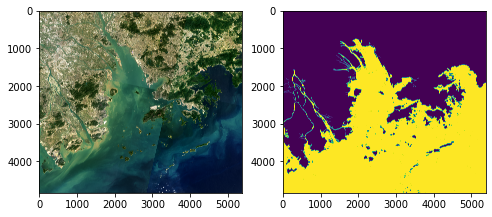

In [4]:
## visualize the remote sensing image and water map
plt.figure(figsize=(8,4))
plt.subplot(121)
imgShow(l8_img)
plt.subplot(122)
plt.imshow(l8_img_wat)


### Add variables to the .nc file

00714T021834_20200714T030256_20200808T181221_2662_060_260______MAR_O_NT_004.SEN3/enhanced_measurement_subs.nc
<ipython-input-5-b94b74842e4c>:48: SerializationWarning: saving variable lat_01 with floating point data as an integer dtype without any _FillValue to use for NaNs
  s3_l2.to_netcdf(path=path_s3l2_new)
<ipython-input-5-b94b74842e4c>:48: SerializationWarning: saving variable lon_01 with floating point data as an integer dtype without any _FillValue to use for NaNs
  s3_l2.to_netcdf(path=path_s3l2_new)
<ipython-input-5-b94b74842e4c>:48: SerializationWarning: saving variable lat_20_ku with floating point data as an integer dtype without any _FillValue to use for NaNs
  s3_l2.to_netcdf(path=path_s3l2_new)
<ipython-input-5-b94b74842e4c>:48: SerializationWarning: saving variable lon_20_ku with floating point data as an integer dtype without any _FillValue to use for NaNs
  s3_l2.to_netcdf(path=path_s3l2_new)
<ipython-input-5-b94b74842e4c>:48: SerializationWarning: saving variable lat

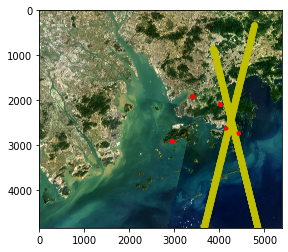

In [5]:
imgShow(l8_img)
for path_s3l2 in files_path:
    print(path_s3l2)
    s3_l2 = xr.open_dataset(path_s3l2)

    '''------1. calculate water percentate in the footprint'''
    col_fps, row_fps = geo2imagexy(lon=s3_l2['lon_20_ku'], lat=s3_l2['lat_20_ku'],img_gdal=img_gdal)
    col_tgauge, row_tgauge = geo2imagexy(lon=tgauge_data['lon'], lat=tgauge_data['lat'], img_gdal=img_gdal)
    plt.plot(col_tgauge, row_tgauge, 'r.')    # visualize the tgauge station  
    plt.plot(col_fps, row_fps, 'y.')    # visualize the footprint
    angle_e = get_fp_angle(row_fps=row_fps,col_fps=col_fps)
    fp_wat_per = get_fps_wat(wat_map=l8_img_wat, angle_e=angle_e, row_fps=row_fps, col_fps=col_fps)
    s3_l2["fp_wat_per"] = (['time_20_ku'], fp_wat_per)
    s3_l2["fp_wat_per"].attrs['name'] = 'surface water percentage in the footprint'

    '''------2. add tgauge station information, e.g., time, location, sea level and distance to fp.'''
    ind_start, ind_end, tgauge_time = tgauge_time_search(tgauge_data=tgauge_data, s3_l2=s3_l2)
    dis_fp_tgauge = tgauge_fp_dist(s3_l2=s3_l2,tgauge_data=tgauge_data,record_id=tgauge_id)
    s3_l2.coords['tgauge_id'] = (['tgauge_id'], np.array([tgauge_id]))
    
    ## location
    s3_l2.coords['lon_tgauge'] = (['num_tgauge'], tgauge_data['lon'].values)
    s3_l2.coords['lat_tgauge'] = (['num_tgauge'], tgauge_data['lat'].values)
    ## time
    s3_l2.coords['time_tgauge']= ('time_tgauge', tgauge_time.values)
    s3_l2.coords['time_tgauge'].attrs['name'] = 'UTC: time corresponding to altimetry data time'
    ## sea level, qb station record_id: 0
    s3_l2['ssha_tgauge'] = ('time_tgauge', tgauge_data['sea_level'][0][ind_start:ind_end+1].values)
    s3_l2['ssha_tgauge'].attrs['name'] = 'sea level from tgauge data'
    s3_l2['ssha_tgauge'].attrs['unit'] = 'meter'
    ## distance to footprint
    s3_l2['dis_fp_tgauge'] = ('time_20_ku', dis_fp_tgauge)
    s3_l2['dis_fp_tgauge'].attrs['name'] = 'distance between the footprint and tide gauge station'
    s3_l2['dis_fp_tgauge'].attrs['unit'] = 'kilometer'

    '''3. add waveform class derived by deep learning model'''
    wf = s3_l2['waveform_20_ku'].values
    wf_nor = [wf[i]/np.max(wf[i]) for i in range(wf.shape[0])] # waveform normalization
    wf_nor = torch.unsqueeze(torch.Tensor(wf_nor), 1)
    pred = model(wf_nor)
    _, pred = torch.max(pred, 1)
    s3_l2["wf_cls"] = (['time_20_ku'], pred.numpy())
    s3_l2["wf_cls"].attrs['name'] = 'waveform class derived by deep learning model, 1 and 0 represent ocean-like waveform and noisy waveform, respectively.'
    # writh to new .nc file
    dir_file = os.path.split(path_s3l2)[0]
    name_file = os.path.split(path_s3l2)[1].split('.')[0]
    path_s3l2_new = os.path.join(dir_file, name_file+'_preproc.nc')
    s3_l2.to_netcdf(path=path_s3l2_new)
